In [1]:
from IPython.display import Audio
import torch
import os
from scipy.io import wavfile
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Sampler, DataLoader
import numpy as np
import torch
import torch.nn as nn

# Play the .wav file
Audio("digits_multiple/659.wav")

In [2]:
class WaveformDataset(Dataset):
    def __init__(self, directory, t_input, max_len, terminal_pad, seq_max_int, seq_t):
        """
        directory: Directory containing the .wav files.
        t_input: Time input array for all files.
        max_len: Maximum length of time steps needed for all files.
        terminal_pad: Number of zeros to pad at the end of each audio file.
        seq_max_int: Maximum number of integers in the padded file name.
        """
        self.directory = directory
        self.files = sorted([f for f in os.listdir(directory) if f.endswith('.wav')], key=lambda x: int(x.split('.')[0]))
        self.t_input = t_input[:max_len]  # Truncate t_input to the maximum required length
        self.terminal_pad = terminal_pad  # Fixed number of zeros to pad
        self.seq_max_int = seq_max_int  # Maximum number of integers in the filename sequence
        self.seq_t = seq_t[:seq_max_int]
        # Prepare padded file name integers during initialization
        self.padded_file_name_integers = self._prepare_padded_filenames()

        # Load and pad audio files
        self.wav_data_list = [self._load_and_pad(os.path.join(directory, f)) for f in self.files]
        self.file_indices = []
        self.total_length = 0

        # Calculate lengths of all files and their indices
        for i, wav_data in enumerate(self.wav_data_list):
            length = wav_data.size(1)  # Assuming data is [channels, time], we take the time dimension
            self.file_indices.extend([(i, j) for j in range(length)])
            self.total_length += length

    def _prepare_padded_filenames(self):
        """
        Converts filenames into sequences of integers, right-padded with 0s up to seq_max_int length.
        """
        padded_filenames = []
        for file_name in self.files:
            # Extract the number from the file name (without the '.wav' extension)
            file_name_base = file_name.split('.')[0]
            # Convert the number into a list of integers
            file_name_integers = [int(char) for char in file_name_base]
            # Pad the list with zeros until it matches the required length
            padded_file_name = file_name_integers + [self.seq_max_int] * (self.seq_max_int - len(file_name_integers))
            #### embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=-1) required!
            # Convert to PyTorch tensor
            padded_filenames.append(torch.tensor(padded_file_name, dtype=torch.long))
        return padded_filenames

    def _load_and_pad(self, file_path):
        """
        Helper function to load, normalize, and pad the audio file.
        """
        sample_rate, data = wavfile.read(file_path)
        data = torch.tensor(data).unsqueeze(0)  # Convert to tensor and add channel dimension

        # Normalize the data to the range [-1, 1] based on int16
        if data.dtype == torch.int16:
            data = data / 32768.0  # Normalize int16 data
        elif data.dtype == torch.int32:
            data = data / 2147483648.0  # Normalize int32 data
        elif data.dtype == torch.float32:
            pass  # If it's already float, assume it's in [-1, 1]

        # Pad the data with zeros at the end
        pad_length = self.terminal_pad
        data_padded = torch.nn.functional.pad(data, (0, pad_length), mode='constant', value=0)
        return data_padded

    def _generate_target(self, wav_data):
        """
        Helper function to generate the target tensor.
        The target will have 1 in all positions except for the final terminal_pad zeros.
        """
        target = torch.ones_like(wav_data)  # Create a target tensor with all ones
        # Set the last terminal_pad positions to zero
        target[:, -self.terminal_pad:] = 0
        return target

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        # Get file and local index from the calculated indices
        file_idx, local_idx = self.file_indices[idx]
        wav_data = self.wav_data_list[file_idx][:, local_idx]  # Slice based on channel and index
        t_step = self.t_input[local_idx]  # Time input for the specific index
        target = self._generate_target(self.wav_data_list[file_idx])[:, local_idx]  # Generate the target tensor

        # Return the padded file name integers for the given file_idx
        padded_file_name_integers = self.padded_file_name_integers[file_idx]

        return wav_data, t_step, target, padded_file_name_integers, self.t_input

    
    
class WaveformDatasetPreload(Dataset):
    def __init__(self, directory, t_input, max_len, terminal_pad, seq_max_int,seq_t):
        """
        directory: Directory containing the .wav files.
        t_input: Time input array for all files.
        max_len: Maximum length of time steps needed for all files.
        terminal_pad: Number of zeros to pad at the end of each audio file.
        seq_max_int: Maximum number of integers in the padded file name.
        """
        self.directory = directory
        self.files = sorted([f for f in os.listdir(directory) if f.endswith('.wav')][:100], key=lambda x: int(x.split('.')[0]))
        self.t_input = t_input[:max_len]  # Truncate t_input to the maximum required length
        self.terminal_pad = terminal_pad  # Fixed number of zeros to pad
        self.seq_max_int = seq_max_int  # Maximum number of integers in the filename sequence
        self.seq_t = seq_t[:seq_max_int]
        # Preload and pad filenames
        self.padded_file_name_integers = self._prepare_padded_filenames()

        # **Change here**: Preload and pad audio files during initialization
        self.wav_data_list = [self._load_and_pad(os.path.join(directory, f)) for f in self.files]
        self.file_indices = []
        self.total_length = 0

        # Calculate lengths of all files and their indices
        for i, wav_data in enumerate(self.wav_data_list):
            length = wav_data.size(1)  # Assuming data is [channels, time], we take the time dimension
            self.file_indices.extend([(i, j) for j in range(length)])
            self.total_length += length

    def _prepare_padded_filenames(self):
        """
        Converts filenames into sequences of integers, right-padded with 0s up to seq_max_int length.
        """
        padded_filenames = []
        for file_name in self.files:
            # Extract the number from the file name (without the '.wav' extension)
            file_name_base = file_name.split('.')[0]
            # Convert the number into a list of integers
            file_name_integers = [int(char) for char in file_name_base]
            # Pad the list with zeros until it matches the required length
            padded_file_name = file_name_integers + [self.seq_max_int] * (self.seq_max_int - len(file_name_integers))
             #### embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=10) required!
            # Convert to PyTorch tensor
            padded_filenames.append(torch.tensor(padded_file_name, dtype=torch.long))
        return padded_filenames

    def _load_and_pad(self, file_path):
        """
        **Change here**: Load and pad audio file only once during initialization.
        """
        sample_rate, data = wavfile.read(file_path)
        data = torch.tensor(data).unsqueeze(0)  # Convert to tensor and add channel dimension

        # Normalize the data to the range [-1, 1] based on int16
        if data.dtype == torch.int16:
            data = data / 32768.0  # Normalize int16 data
        elif data.dtype == torch.int32:
            data = data / 2147483648.0  # Normalize int32 data
        elif data.dtype == torch.float32:
            pass  # If it's already float, assume it's in [-1, 1]

        # Pad the data with zeros at the end
        pad_length = self.terminal_pad
        data_padded = torch.nn.functional.pad(data, (0, pad_length), mode='constant', value=0)
        return data_padded

    def _generate_target(self, wav_data):
        """
        Helper function to generate the target tensor.
        The target will have 1 in all positions except for the final terminal_pad zeros.
        """
        target = torch.ones_like(wav_data)  # Create a target tensor with all ones
        # Set the last terminal_pad positions to zero
        target[:, -self.terminal_pad:] = 0
        return target

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        # **No file loading happens here**; just retrieving preloaded data
        file_idx, local_idx = self.file_indices[idx]
        wav_data = self.wav_data_list[file_idx][:, local_idx]  # Slice based on channel and index
        t_step = self.t_input[local_idx]  # Time input for the specific index
        target = self._generate_target(self.wav_data_list[file_idx])[:, local_idx]  # Generate the target tensor

        # Return the preprocessed padded file name integers for the given file_idx
        padded_file_name_integers = self.padded_file_name_integers[file_idx]

        num_padding = (padded_file_name_integers == self.seq_max_int).sum().item()

        # Retain only non-padded values in seq_t and zero out the rest
        retained_len = len(self.seq_t) - num_padding
        seq_t_adjusted = self.seq_t.clone()  # Clone to avoid modifying the original tensor
        if retained_len > 0:
            seq_t_adjusted[retained_len:] = 0  # Zero out the right-padded elements

        return wav_data, t_step, target, padded_file_name_integers, seq_t_adjusted

class WaveformDatasetLazy(Dataset):
    def __init__(self, directory, t_input, max_len, terminal_pad, seq_max_int):
        """
        directory: Directory containing the .wav files.
        t_input: Time input array for all files.
        max_len: Maximum length of time steps needed for all files.
        terminal_pad: Number of zeros to pad at the end of each audio file.
        seq_max_int: Maximum number of integers in the padded file name.
        """
        self.directory = directory
        self.files = sorted([f for f in os.listdir(directory) if f.endswith('.wav')], key=lambda x: int(x.split('.')[0]))
        self.t_input = t_input[:max_len]  # Truncate t_input to the maximum required length
        self.terminal_pad = terminal_pad  # Fixed number of zeros to pad
        self.seq_max_int = seq_max_int  # Maximum number of integers in the filename sequence

        # Precompute and store padded filenames
        self.padded_file_name_integers = self._prepare_padded_filenames()

        # Only precompute targets (small data) to save memory
        self.target_list = self._precompute_targets()

        self.file_indices = []
        self.total_length = 0

        # Calculate lengths of all files and their indices
        for i, target in enumerate(self.target_list):
            length = target.size(1)  # Get the time dimension
            self.file_indices.extend([(i, j) for j in range(length)])
            self.total_length += length

    def _prepare_padded_filenames(self):
        """
        Converts filenames into sequences of integers, right-padded with 0s up to seq_max_int length.
        """
        padded_filenames = []
        for file_name in self.files:
            # Extract the number from the file name (without the '.wav' extension)
            file_name_base = file_name.split('.')[0]
            # Convert the number into a list of integers
            file_name_integers = [int(char) for char in file_name_base]
            # Pad the list with zeros until it matches the required length
            padded_file_name = file_name_integers + [-1] * (self.seq_max_int - len(file_name_integers))
             #### embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=-1) required!
            # Convert to PyTorch tensor
            padded_filenames.append(torch.tensor(padded_file_name, dtype=torch.long))
        return padded_filenames

    def _load_and_pad(self, file_path):
        """
        Lazy-load and pad audio file when needed (not preloaded to save memory).
        """
        sample_rate, data = wavfile.read(file_path)
        data = torch.tensor(data).unsqueeze(0)  # Convert to tensor and add channel dimension

        # Normalize the data to the range [-1, 1] based on int16
        if data.dtype == torch.int16:
            data = data / 32768.0  # Normalize int16 data
        elif data.dtype == torch.int32:
            data = data / 2147483648.0  # Normalize int32 data
        elif data.dtype == torch.float32:
            pass  # If it's already float, assume it's in [-1, 1]

        # Pad the data with zeros at the end
        pad_length = self.terminal_pad
        data_padded = torch.nn.functional.pad(data, (0, pad_length), mode='constant', value=0)
        return data_padded

    def _precompute_targets(self):
        """
        Precompute target tensors once during initialization (small data).
        """
        target_list = []
        for file_name in self.files:
            # Load and pad the corresponding wav file for target generation
            wav_data = self._load_and_pad(os.path.join(self.directory, file_name))
            target = self._generate_target(wav_data)
            target_list.append(target)
        return target_list

    def _generate_target(self, wav_data):
        """
        Helper function to generate the target tensor.
        The target will have 1 in all positions except for the final terminal_pad zeros.
        """
        target = torch.ones_like(wav_data)  # Create a target tensor with all ones
        # Set the last terminal_pad positions to zero
        target[:, -self.terminal_pad:] = 0
        return target

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        file_idx, local_idx = self.file_indices[idx]

        # Lazy load wav data (to avoid memory overload during initialization)
        wav_data = self._load_and_pad(os.path.join(self.directory, self.files[file_idx]))[:, local_idx]  # Slice

        # Retrieve precomputed target
        target = self.target_list[file_idx][:, local_idx]

        # Retrieve precomputed padded file name
        padded_file_name_integers = self.padded_file_name_integers[file_idx]

        # Get the corresponding time step
        t_step = self.t_input[local_idx]

        return wav_data, t_step, target, padded_file_name_integers


In [3]:


class RandomConsecutiveSampler(Sampler):
    def __init__(self, data_source, batch_size, consecutive_size):
        """
        data_source: Dataset that returns (wav_data, time_step, file_idx)
        batch_size: Number of consecutive segments in each batch
        consecutive_size: How many consecutive steps to take for each sampled segment
        """
        self.data_source = data_source
        self.batch_size = batch_size
        self.consecutive_size = consecutive_size

    def __iter__(self):
        indices = np.random.permutation(len(self.data_source) - self.consecutive_size + 1)
        for i in range(0, len(indices), self.batch_size):
            batch_indices = []
            for j in range(i, min(i + self.batch_size, len(indices))):
                start_idx = indices[j]
                batch_indices.extend(range(start_idx, start_idx + self.consecutive_size))
            yield batch_indices

    def __len__(self):
        return (len(self.data_source) - self.consecutive_size ) // self.batch_size

class ConsecutiveDifferenceHigherOrderLossBatch(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLossBatch, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[ 1:, :]
        pred_b = pred_reshape[:-1,:]
        target_a = target_reshape[ 1:, :]
        target_b = target_reshape[:-1,:]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[ 1:, :]
            pred_b = pred_dif[:-1,:]
            target_a = target_dif[ 1:, :]
            target_b = target_dif[:-1,:]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result
    
class ConsecutiveDifferenceHigherOrderLoss(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLoss, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[:, 1:]
        pred_b = pred_reshape[:, :-1]
        target_a = target_reshape[:, 1:]
        target_b = target_reshape[:, :-1]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[:, 1:]
            pred_b = pred_dif[:, :-1]
            target_a = target_dif[:, 1:]
            target_b = target_dif[:, :-1]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result


def get_max_required_length(dir):
    max_length = 0
    
    # Iterate over all files in the directory
    for filename in os.listdir(dir):
        if filename.endswith('.wav'):  # Only process .wav files
            file_path = os.path.join(dir, filename)
            
            # Read the .wav file
            sample_rate, data = wavfile.read(file_path)
            
            # Get the length of the audio file (number of samples)
            file_length = data.shape[0]  # shape[0] gives the number of samples (time dimension)
            
            # Update the max length if this file is longer
            if file_length > max_length:
                max_length = file_length

    return max_length

#import torch
#import torch.nn as nn
#import torch.optim as optim



def binary_sequence_tensor(num_bits, length):
    # Create a tensor of shape (length,) with values from 0 to length - 1
    t_values = torch.arange(1,length+1) #start with 1

    # Create a tensor to store the binary representations
    binary_tensor = ((t_values.unsqueeze(1) >> torch.arange(num_bits)) & 1).float()
    binary_tensor[binary_tensor == 0] = -1
    return binary_tensor
    

In [8]:
directory = "digits_multiple/"

In [82]:
target_pad = 20
bits = 16
seq_bits = 4
seq_max_len = 10

max_len = get_max_required_length(directory)

t_input = binary_sequence_tensor(bits, max_len+ target_pad)  # Example, adjust this to match your real t_input
seq_t_input = binary_sequence_tensor(seq_bits, seq_max_len + 1) 


#this is for validating
#t_input = np.linspace(1,max_len + target_pad,max_len + target_pad)

# Instantiate the dataset
dataset = WaveformDatasetPreload(directory, t_input, max_len, target_pad ,seq_max_len, seq_t_input )

# Sampler setup as before
batch_size = 50
consecutive_size = 20
sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)

# DataLoader
dataloader = DataLoader(dataset, batch_sampler=sampler)


In [83]:
for batch in dataloader:
    wav_data, t_step, target, file_idx, seq_inputs = batch #right now this wraps arround, just fyi.  not sure its a bad thing.


    print("Waveform data:", wav_data.shape)
    print("Time step:", t_step.shape)
    print("Target tensor:", target.shape)
    print("File index:", file_idx.shape)
    print("File index:", seq_inputs.shape)
    break

Waveform data: torch.Size([1000, 1])
Time step: torch.Size([1000, 16])
Target tensor: torch.Size([1000, 1])
File index: torch.Size([1000, 10])
File index: torch.Size([1000, 10, 4])


In [84]:


class SeqEmbedding(nn.Module):
    def __init__(self, seq_bits, vocab_len, embedding_dim, hidden_dim, output_dim, num_layers, padding_idx=-1):
        super(SeqEmbedding, self).__init__()
        # Embedding layer with padding index
        self.embedding = nn.Embedding(vocab_len, embedding_dim, padding_idx=padding_idx)
        self.fc_layers = nn.ModuleList()

        # First layer takes in concatenated input (seq_bits + embedding_dim) and outputs to hidden_dim
        self.fc_layers.append(nn.Linear(seq_bits + embedding_dim, hidden_dim))

        # Create intermediate hidden layers if num_layers > 1
        for _ in range(num_layers - 2):
            self.fc_layers.append(nn.Linear(hidden_dim, hidden_dim))

        # Final layer goes from hidden_dim to output_dim
        self.fc_layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, t_seq, seq_indices):
        # Pass the seq_indices through the embedding layer
    
        embedded_seq = self.embedding(seq_indices)
        # Concatenate t_seq and embedded_seq along the last dimension
        
        
        x = torch.cat((t_seq, embedded_seq), dim=-1)
        # Pass through all the fully connected layers
        for layer in self.fc_layers:
            x = torch.relu(layer(x))  # Apply ReLU after each layer
        
        return x


class SeqInput(nn.Module):
    def __init__(self, seq_bits, input_embedding_dim, hidden_dim, output_dim, num_layers,vocab_len, padding_idx = -1):
        super(SeqInput, self).__init__()
        self.embedding = nn.Embedding(vocab_len, input_embedding_dim, padding_idx=padding_idx)
        self.fc_layers = nn.ModuleList()  # To store the layers

        # First layer takes in concatenated input (seq_bits + input_embedding_dim) and outputs to hidden_dim
        self.fc_layers.append(nn.Linear(seq_bits + 2*input_embedding_dim, hidden_dim))

        # Create intermediate hidden layers if num_layers > 1
        for _ in range(num_layers - 2):
            self.fc_layers.append(nn.Linear(hidden_dim, hidden_dim))

        # Final layer goes from hidden_dim to output_dim
        self.fc_layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, t_seq, input_embedding,seq_indices):
        # Concatenate t_seq and input_embedding along the last dimension
        embedding = self.embedding(seq_indices)
        x = torch.cat((t_seq, input_embedding,embedding), dim=-1) ## i need the individual file here too!!
       
        # Pass through all the fully connected layers
        for layer in self.fc_layers:
            x = torch.relu(layer(x))  # Apply ReLU after each layer

        return x


class FileEmbeddingModel(nn.Module):
    def __init__(self, embedding_input_dim, bits, hidden_dim, num_layers):
        super(FileEmbeddingModel, self).__init__()
        
        input_dim = bits + embedding_input_dim  # Adjust input dimension
        # Create a list of layers
        layers = []
        for i in range(num_layers):
            in_features = input_dim if i == 0 else hidden_dim
            out_features = hidden_dim
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())  # Add ReLU activation after each linear layer
        
        # Use nn.Sequential to stack the layers
        self.hidden_layers = nn.Sequential(*layers)
        
        # Output layers for binary cross-entropy and MSE
        self.bce_output = nn.Linear(hidden_dim, 1)  # For binary cross-entropy (single scalar)
        self.mse_output = nn.Linear(hidden_dim, 1)  # For mean squared error (single scalar)
        
    def forward(self, embedding_tensor, bits_tensor):
        # Concatenate the input embedding with the bits_tensor
        concatenated = torch.cat((embedding_tensor, bits_tensor), dim=1)  # Output: [batch_size, bits + embedding_input_dim]
        
        # Pass through the dynamically created hidden layers
        hidden_out = self.hidden_layers(concatenated)
        
        # Compute both outputs
        bce_out = torch.sigmoid(self.bce_output(hidden_out))  # Binary classification output
        mse_out = self.mse_output(hidden_out)  # Regression output
        
        return bce_out, mse_out


In [85]:
class SeqEncodingSeqPred(nn.Module):
    def __init__(self, hyperparams):
        super(SeqEncodingSeqPred, self).__init__()
        # Initialize hyperparameters from nested dict
        seq_embedding_params = hyperparams['seq_embedding']
        seq_input_params = hyperparams['seq_input']
        file_embedding_params = hyperparams['file_embedding']

        # Instantiate SeqEmbedding
        self.seq_embedding = SeqEmbedding(
            seq_embedding_params['seq_bits'],
            seq_embedding_params['vocab_len'],
            seq_embedding_params['embedding_dim'],
            seq_embedding_params['hidden_dim'],
            seq_embedding_params['output_dim'],
            seq_embedding_params['num_layers'],
            seq_embedding_params['padding_idx']
        )

        # Instantiate SeqInput
        self.seq_input = SeqInput(
            seq_input_params['seq_bits'],
            seq_input_params['input_embedding_dim'],
            seq_input_params['hidden_dim'],
            seq_input_params['output_dim'],
            seq_input_params['num_layers'],
            seq_embedding_params['vocab_len'],
            seq_embedding_params['padding_idx']
        )

        # Instantiate FileEmbeddingModel
        self.file_embedding = FileEmbeddingModel(
            file_embedding_params['embedding_input_dim'],
            file_embedding_params['bits'],
            file_embedding_params['hidden_dim'],
            file_embedding_params['num_layers']
        )

    def forward(self, t_seq, seq_indices, t):
        # Pass t_seq and file_vector through SeqEmbedding
        seq_embedding_output = self.seq_embedding(t_seq, seq_indices)
       
        # Sum over the last dimension of SeqEmbedding's output
        summed_seq_embedding_output = torch.sum(seq_embedding_output, dim=-2)
        summed_seq_embedding_output = summed_seq_embedding_output.unsqueeze(1)
        summed_seq_embedding_output = summed_seq_embedding_output.repeat(1, 10, 1)
        
        # Pass summed output and t_seq through SeqInput
        seq_input_output = self.seq_input(t_seq, summed_seq_embedding_output, seq_indices)

        # Sum over the last dimension of SeqInput's output
        summed_seq_input_output = torch.sum(seq_input_output, dim=-2)
        
        # Pass the summed output and t through FileEmbeddingModel
        bce_out, mse_out = self.file_embedding(summed_seq_input_output, t)

        return bce_out, mse_out


# Example of hyperparameters as a nested dict
hyperparams = {
    'seq_embedding': {
        'seq_bits': 4,
        'vocab_len': 11,
        'embedding_dim': 32,
        'hidden_dim': 64,
        'output_dim': 128,
        'num_layers': 3,
        'padding_idx': 10
    },
    'seq_input': {
        'seq_bits': 4, #must match above
        'input_embedding_dim': 128, #must match output_dim above
        'hidden_dim': 64,
        'output_dim': 128,
        'num_layers': 3
    },
    'file_embedding': {
        'embedding_input_dim': 128,
        'bits': 16, #from external.  
        'hidden_dim': 64,
        'num_layers': 3
    }
}

# Instantiate the model with the hyperparameters
model = SeqEncodingSeqPred(hyperparams)

In [86]:
model

SeqEncodingSeqPred(
  (seq_embedding): SeqEmbedding(
    (embedding): Embedding(11, 32, padding_idx=10)
    (fc_layers): ModuleList(
      (0): Linear(in_features=36, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
    )
  )
  (seq_input): SeqInput(
    (embedding): Embedding(11, 128, padding_idx=10)
    (fc_layers): ModuleList(
      (0): Linear(in_features=260, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
    )
  )
  (file_embedding): FileEmbeddingModel(
    (hidden_layers): Sequential(
      (0): Linear(in_features=144, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
    )
    (bce_output): Linear(in_features=64, out_f

In [87]:
for batch in dataloader:
    wav_data, t_step, target, file_idx, seq_inputs = batch #right now this wraps arround, just fyi.  not sure its a bad thing.
    

    f = model(seq_inputs,file_idx,t_step)
    print(f[0].shape, f[1].shape)
    break

torch.Size([1000, 1]) torch.Size([1000, 1])


In [88]:
# for tomorrow, tidy up the hyperparam.  no duplicates, and now multiple inputs for things that must be equal.  
#train!!
#also, add some distance from their common embedding from the binary thing to the wav output thing.  

In [89]:
from tqdm import tqdm 

In [90]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
mse_loss_fn = nn.MSELoss()
bce_loss_fn = nn.BCELoss()
cdifb_loss = ConsecutiveDifferenceHigherOrderLossBatch(consecutive_size,order=3)
cdif_loss = ConsecutiveDifferenceHigherOrderLoss(consecutive_size,order=3)

num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    #for batch in dataloader:
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        wav_data, t_step, target, file_idx, seq_inputs  = batch
        
        bce_output, mse_output = model(seq_inputs,file_idx,t_step)
        
        # Compute losses
        mse_loss = mse_loss_fn(mse_output*target, wav_data)  # Assuming the target is for MSE
        bce_loss = bce_loss_fn(bce_output, target)  # Assuming the target is for BCE
        cdif = cdif_loss(mse_output*target, wav_data)
        #bc = bc_loss(outputs, targets)
        cdif_b = cdifb_loss(mse_output*target, wav_data)
        
        
        # Combine losses (you can weight them if needed)
        total_loss = mse_loss + 0.1*bce_loss + 1.6*cdif + 0.4*cdif_b
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} MSE: {mse_loss.item():.6f} BCE: {bce_loss.item():.6f} CDIF: {cdif.item():.6f} CDIF_B: {cdif_b.item():.6f} Total Loss: {total_loss.item():.8f}")

print("all done sweetheart <3")

Epoch 1/1:   1%|▏                        | 874/111256 [01:34<3:18:21,  9.27it/s]


KeyboardInterrupt: 

In [30]:
#torch.save(model, "digits5k_first_try.pth")

In [ ]:
model = torch.load("digits5k_second_try.pth")

# Set the model to evaluation mode (if you're using it for inference)
model.eval()

In [70]:
digits = "40599"
rep = t_input.shape[0] #this is good, 
input_seq_1 = seq_t_input[:-1]

file = [int(char) for char in digits] 
input_seq_1[len(file):] = 0

file = file + [10] * (10 - len(file))
file = torch.tensor(file)
file = file.unsqueeze(0).repeat(rep,1)
input_seq_eval = input_seq_1.unsqueeze(0).repeat(rep, 1,1)

print(file.shape,input_seq_eval.shape, t_input.shape )


torch.Size([93069, 10]) torch.Size([93069, 10, 4]) torch.Size([93069, 16])


In [71]:
# Assuming input shapes: (batch_size, ...)
# Define your eval batch size
eval_batch_size = 20

# Initialize lists to store outputs
bce_outputs = []
mse_outputs = []

# Get the total number of batches
total_batches = (file.shape[0] + eval_batch_size - 1) // eval_batch_size

# Loop over batches
for i in range(total_batches):
    # Define the start and end of the batch
    start_idx = i * eval_batch_size
    end_idx = min((i + 1) * eval_batch_size, file.shape[0])

    # Slice the batch from each input
    batch_file = file[start_idx:end_idx]
    batch_input_seq_eval = input_seq_eval[start_idx:end_idx]
    batch_t_input = t_input[start_idx:end_idx]

    # Run the model in evaluation mode (assuming the model is in eval mode already)
    with torch.no_grad():  # Disable gradient calculation for evaluation
        bce_output, mse_output = model(batch_input_seq_eval, batch_file, batch_t_input)
    
    # Append the outputs
    bce_outputs.append(bce_output)
    mse_outputs.append(mse_output)

# Optionally, concatenate the outputs into single tensors
bce_outputs = torch.cat(bce_outputs, dim=0)
mse_outputs = torch.cat(mse_outputs, dim=0)

# Now bce_outputs and mse_outputs contain the model outputs for all batches


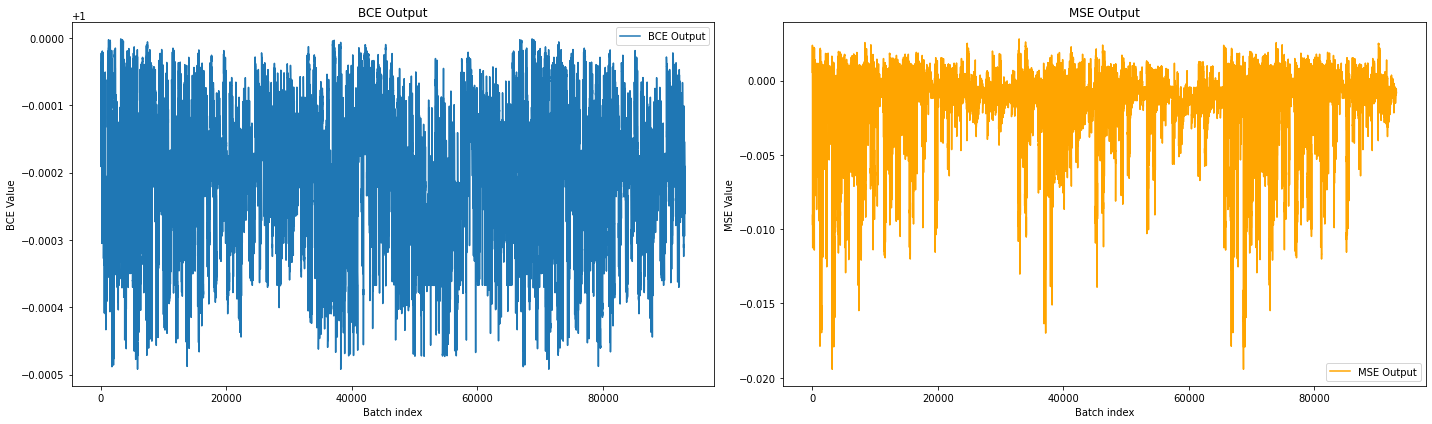

In [72]:
import matplotlib.pyplot as plt




# Create a figure and plot both outputs
plt.figure(figsize=(20, 6))

# Plot BCE outputs
plt.subplot(1, 2, 1)
plt.plot(bce_outputs.numpy(), label='BCE Output')
plt.title('BCE Output')
plt.xlabel('Batch index')
plt.ylabel('BCE Value')
plt.legend()

# Plot MSE outputs
plt.subplot(1, 2, 2)
plt.plot(mse_outputs.numpy(), label='MSE Output', color='orange')
plt.title('MSE Output')
plt.xlabel('Batch index')
plt.ylabel('MSE Value')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [73]:
import torch
import numpy as np
from scipy.io.wavfile import write


def tensor_to_wav(tensor, filename, sample_rate=44100,cut_off=-1 ):
    # Convert tensor to numpy array and detach if needed
    data = tensor.detach().cpu().numpy()[:cut_off]
    # Normalize to the range [-1, 1]
    #data = data / np.max(np.abs(data))

    # Convert to 16-bit PCM format (values between -32768 and 32767)
    data_int16 = np.int16(data * 32768)

    # Write the .wav file
    write(filename, sample_rate, data_int16)
    print(f"Saved as {filename}")

# Example usage with your model predictions (assuming predictions are in range -1 to 1):
# predictions is the output tensor from the model
tensor_to_wav(mse_outputs, "test_mult_first_bad.wav")

Saved as test_mult_first_bad.wav


In [74]:
from IPython.display import Audio

# Play the .wav file
Audio("test_mult_first_bad.wav")

In [ ]:
in seq embedding, you need the individual file again.  it needs its own embedding at that layer too!!

In [ ]:
#the forward for eval is not super efficient, we only need to run the seq stuff once.  idk.  not super important right now.  
